# 프로젝트 : CIFAR-10 이미지 생성하기

STEP 1. 작업환경 구성하기

mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples

mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints

mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

작성하며 고려해야 할 사항

1. image data shape = (32,32,3)
2. image RGB 3channel

In [3]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


STEP 2. 데이터셋 구성하기

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import time

import PIL
import imageio
import numpy as np
from tensorflow.keras import layers
from IPython import display

In [8]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

학습에 사용할 train_x의 이미지를 -1, 1로 정규화

로드한 학습 데이터를 시각화를 통해 확인

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [9]:
train_x = (train_x - 127.5)/127.5
train_x

array([[[[-0.5372549 , -0.51372549, -0.50588235],
         [-0.6627451 , -0.63921569, -0.64705882],
         [-0.60784314, -0.62352941, -0.6627451 ],
         ...,
         [ 0.23921569,  0.03529412, -0.15294118],
         [ 0.19215686, -0.01960784, -0.2       ],
         [ 0.16078431, -0.02745098, -0.19215686]],

        [[-0.8745098 , -0.84313725, -0.84313725],
         [-1.        , -1.        , -1.        ],
         [-0.85882353, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.30980392, -0.56862745],
         [-0.06666667, -0.34901961, -0.60784314],
         [-0.04313725, -0.31764706, -0.55294118]],

        [[-0.80392157, -0.81176471, -0.83529412],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.61568627, -0.78823529, -0.9372549 ],
         ...,
         [-0.0745098 , -0.34117647, -0.60784314],
         [-0.05882353, -0.34117647, -0.60784314],
         [-0.14509804, -0.42745098, -0.67058824]],

        ...,

        [[ 0.63137255,  0.33333333, -0

In [10]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


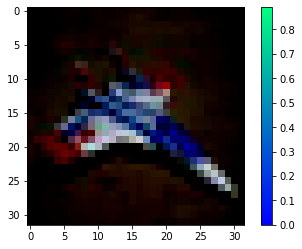

In [15]:
plt.imshow(train_x[30], cmap='winter' )
plt.colorbar()
plt.show()

In [16]:
BUFFER_SIZE = 50000
BATCH_SIZE=256


In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

STEP 3. 생성자 모델 구현하기

In [25]:
def make_generator_model():
    
    model=tf.keras.Sequential()
    
    #1 dense
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #2 reshape
    model.add(layers.Reshape((8,8,256)))
    
    #3 Conv2DTranspose
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #4 conv2DTranspose
    model.add(layers.Conv2DTranspose(256, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #5 Conv2DTranspose
    model.add(layers.Conv2DTranspose(3,kernel_size=(5,5),strides=(2,2),padding='same', use_bias=False, activation='tanh'))
    
    return model


    

In [26]:
generator = make_generator_model()

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

In [27]:
noise = tf.random.normal([1, 100])

In [28]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

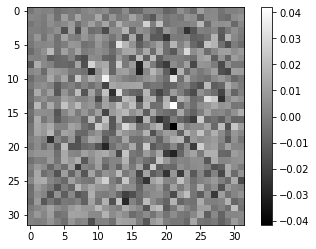

In [29]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [33]:
def make_discriminator_model():
    #Start
    model = tf.keras.Sequential()
    
    #1. Conv2D Layer
    model.add(layers.Conv2D(64,(5,5),strides=(2,2), padding='same', input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #2. Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #3. Flatten Layer
    model.add(layers.Flatten())
    
    #4. DenseLayer
    model.add(layers.Dense(1))
    
    return model
    
    

In [34]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

STEP3에서 생성한 이미지 판별 정확도 계산

In [35]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00266751]], dtype=float32)>

numpy=array([[0.00266751]], dtype=float32) 정확도가 0.26%로 나왔다


STEP 5. 손실함수와 최적화 함수 구현하기

생성자와 판별자의 손실함수(loss)를 구현해 봅시다.

판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.

생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [37]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #손실함수로 이진 교차엔트로피 사용 상호간에 거리가 줄어들떄 사용

In [38]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [39]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [40]:
#판별기 정확도 -> real_accuracy는 
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])),tf.float32))
    return real_accuracy , fake_accuracy

    

In [41]:
#옵티마이저 따로 만들어줘야함
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)


STEP 6. 훈련과정 상세 기능 구현하기

1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.

16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.

훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는
draw_train_history() 함수를 구현해 봅시다.

training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [42]:
noise_dim=100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [43]:
#1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
@tf.function
def train_step(images): #입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) #생성자 입력 노이즈
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #3 GradientTape 오픈
        generated_images = generator(noise, training=True) #4 gernerated images 생성 (generator은 training 해야됨)
        
        #5 discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        #6 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        #7 accuracy 계산
        real_accuracy , fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    #8 gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    #9 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy # return

        
    

In [45]:
#16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions=model(sample_seeds, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0], cmap='gray')
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv("HOME"), epoch, it))
    plt.show()
        

In [46]:
#훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는
#draw_train_history() 함수를 구현해 봅시다.
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 15,6 # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    #summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')  
    plt.xlabel('batch iters')
    plt.legend(['gen_loss','disc_loss'],loc='upper left')
    
    #summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator_accuracy')
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters') 
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    #training_history directory에 epoch별로 그래프 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()
    

In [47]:
#training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.
checkpoint_dir = os.getenv("HOME")+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix=os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer = discriminator_optimizer,
                                generator=generator, discriminator=discriminator)

In [48]:
def train(dataset, epochs, save_every):
    start = time.time()
    history={'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy,fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator,epochs, it, seed)
        print('TIme for training : {} sec'.format(int(time.time()-start)))
        
        draw_train_history(history, epoch)
        

STEP 7. 학습 과정 진행하기

위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.

학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.

학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [49]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

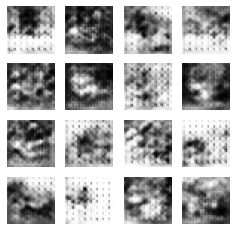

TIme for training : 1054 sec


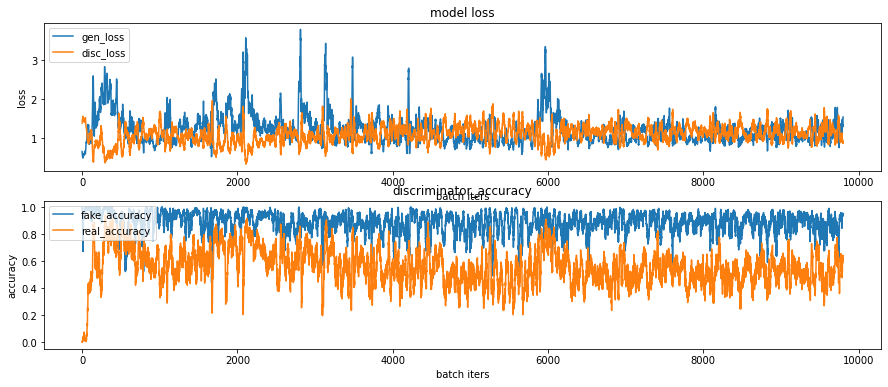

CPU times: user 17min 57s, sys: 1min 18s, total: 19min 16s
Wall time: 17min 35s


In [50]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

다음 모델을 통한 정확도를 보게되면, fake_accuracy가 1이되고 있는 모습을 볼 수 있는데, 학습이 제대로 이뤄지지 않은 모습을 볼수있다.
그리고 이미지 또한 정확한 이미지로 분류되지 못한 모습이다.



In [52]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1125038 Dec 13 08:43 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


STEP 8. (optional) GAN 훈련 과정 개선하기

STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.

모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

https://github.com/soumith/ganhacks

https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf